# Sram EDA and Analysis

## (Please reference accompanying powerpoint for detailed walkthrough of analysis) 
#### Using the provided volume data in excel, advise the Product Management team on what should be prioritized for each of the components and what the tradeoffs might be (if any)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


#import data
df = pd.read_csv(r"C:\Users\brand\Downloads\sram_data.csv")

#clean up col names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.rename(columns = {'materail_name':'material_name'}, inplace = True)

#preview
df.head()

,category,segment,product_type,model_code,material_name,calendar_year,tier,chainring_size,crank_arm_length,1x_or_2x,sales_year_group,net_volume
0,Road,Aftermarket,Power Meters,PM-RED-1-D1,AM PM RED 1 AXS D1 DUB 170 36,2020,Tier 1: Red,36T,170MM,1x,2019/20,1
1,Road,Aftermarket,Power Meters,PM-RED-1-D1,AM PM RED 1 AXS D1 DUB 170 36,2021,Tier 1: Red,36T,170MM,1x,2021/22,1
2,Road,Aftermarket,Power Meters,PM-RED-1-D1,AM PM RED 1 AXS D1 DUB 170 36,2022,Tier 1: Red,36T,170MM,1x,2021/22,1
3,Road,Aftermarket,Power Meters,PM-RED-1-D1,AM PM RED 1 AXS D1 DUB 1725 36,2021,Tier 1: Red,36T,172.5MM,1x,2021/22,3
4,Road,Aftermarket,Power Meters,PM-RED-1-D1,AM PM RED 1 AXS D1 DUB 175 36,2021,Tier 1: Red,36T,175MM,1x,2021/22,1


### Data Understanding and Preparation

1. Deal with duplicated entries, NA values, irrelevant observations
2. Feature/column creation?
3. Understand data types, summary tables, distributions.

In [2]:
#remove observations with both NO ARM and NO CR
#Cycling is highly seasonal, drop 2023 data 
df = df.drop(df[(df['crank_arm_length'] == 'NO ARM') & (df['chainring_size'] == 'NO RINGS')].index)
df = df.drop(df[(df['calendar_year'] == 2023)].index)

In [3]:
df.dtypes

category            object
segment             object
product_type        object
model_code          object
material_name       object
calendar_year        int64
tier                object
chainring_size      object
crank_arm_length    object
1x_or_2x            object
sales_year_group    object
net_volume          object
dtype: object

Looks like most columns are coded as strings. We'll want to transform "net_volume" into integer for analysis

In [4]:
#This throws an error. Looks like some values have commas causing the column to default as a string
#pd.to_numeric(df['net_volume'])

#set net_volume as numeric
df['net_volume'] = df['net_volume'].str.replace(",", "")
df['net_volume'] = pd.to_numeric(df['net_volume'])

#no duplicate rows
#df.loc[df.duplicated()]

In [5]:
df.describe()

,calendar_year,net_volume
count,6050.000000,6050.000000
mean,2019.464793,254.395207
std,1.684535,1003.411670
min,2017.000000,-146.000000
25%,2018.000000,5.000000
50%,2019.000000,29.000000
75%,2021.000000,150.000000
max,2022.000000,27255.000000


net_volume shoudn't have negative values or values of '0'. Large max values aren't disqualifying, important to understand which specs are ordered in bulk

In [6]:
#Take the absolute value of all values. Drop '0' values
df['net_volume'] = abs(df['net_volume'])
df = df[df['net_volume'] != 0]

df['calendar_year'] = df['calendar_year'].astype(str) 

In [7]:
df.dtypes

category            object
segment             object
product_type        object
model_code          object
material_name       object
calendar_year       object
tier                object
chainring_size      object
crank_arm_length    object
1x_or_2x            object
sales_year_group    object
net_volume           int64
dtype: object

Now that net_volume is cleaned up I want to understand: <br>
1. Which products are the driving the high volume orders?
2. Where are NA values?

In [8]:
df.nlargest(5, 'net_volume')

,category,segment,product_type,model_code,material_name,calendar_year,tier,chainring_size,crank_arm_length,1x_or_2x,sales_year_group,net_volume
3410,Road,Original Equipment,Cranksets,FC-RIV-D1,FC RIVAL D1 DUB 1725 4835,2021,Tier 3: Rival,48/35T,172.5MM,2x,2021/22,27255
3142,Road,Original Equipment,Cranksets,FC-RIV-1W-D1,FC RIVAL 1 D1 DUB WIDE 1725 40,2022,Tier 3: Rival,40T,172.5MM,1x,2021/22,24254
3411,Road,Original Equipment,Cranksets,FC-RIV-D1,FC RIVAL D1 DUB 1725 4835,2022,Tier 3: Rival,48/35T,172.5MM,2x,2021/22,19542
3616,Road,Original Equipment,Cranksets,FC-Apex-1-A1,FC APEX 1 24MM 1725 XSYNC 40,2022,Tier 4,40T,172.5MM,1x,2021/22,18674
3292,Road,Original Equipment,Cranksets,FC-RIV-D1,FC RIVAL D1 DUB 1725 4633,2022,Tier 3: Rival,46/33T,172.5MM,2x,2021/22,16966


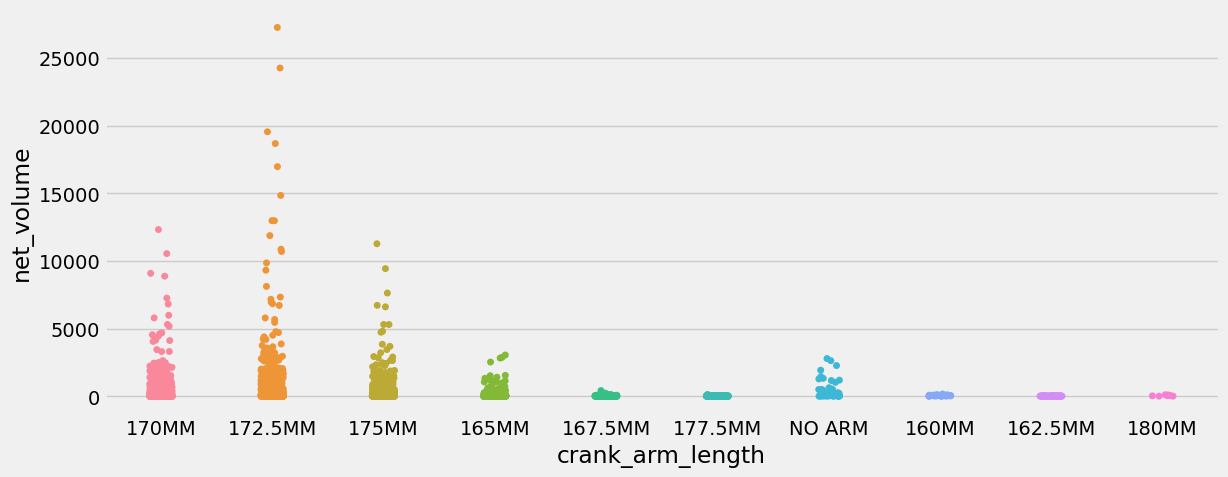

In [10]:
sns.catplot(data = df, x = 'crank_arm_length', y = 'net_volume', aspect = 2.5)

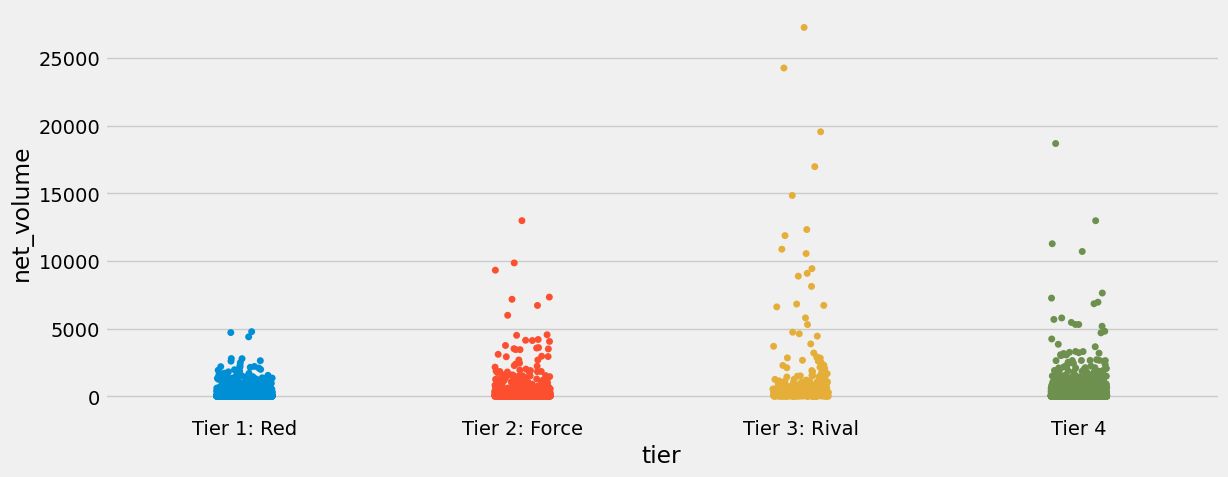

In [11]:
sns.catplot(data = df, x = 'tier', y = 'net_volume', aspect = 2.5)

The distribuition is heavily right-skewed. Tiers 4 and 3 have the greatest # of sales > 5000

In [12]:
df.isna().sum()

category              0
segment               0
product_type          0
model_code            0
material_name         0
calendar_year         0
tier                  0
chainring_size        0
crank_arm_length      0
1x_or_2x            801
sales_year_group      0
net_volume            0
dtype: int64

In [13]:
df[df['1x_or_2x'].isnull()].head()

,category,segment,product_type,model_code,material_name,calendar_year,tier,chainring_size,crank_arm_length,1x_or_2x,sales_year_group,net_volume
1229,Road,Aftermarket,Cranksets,FC-RED-D1,FC RED D1 DUB 165 NO RING/SPDR RACE,2019,Tier 1: Red,NO RINGS,165MM,NaN,2019/20,8
1230,Road,Aftermarket,Cranksets,FC-RED-D1,FC RED D1 DUB 165 NO RING/SPDR RACE,2020,Tier 1: Red,NO RINGS,165MM,NaN,2019/20,42
1231,Road,Aftermarket,Cranksets,FC-RED-D1,FC RED D1 DUB 165 NO RING/SPDR RACE,2021,Tier 1: Red,NO RINGS,165MM,NaN,2021/22,76
1232,Road,Aftermarket,Cranksets,FC-RED-D1,FC RED D1 DUB 165 NO RING/SPDR RACE,2022,Tier 1: Red,NO RINGS,165MM,NaN,2021/22,164
1234,Road,Aftermarket,Cranksets,FC-RED-D1,FC RED D1 DUB 1675 NO RING/SPDR RACE,2019,Tier 1: Red,NO RINGS,167.5MM,NaN,2019/20,12


Several cranksets do not have 1x or 2x data. However, aggregate functions will automatically drop NaN for 1x/2x analysis. Important to leave in for crank arm analysis

### Aggregate Visualizations

Given the wide dataset with many categorical variables, starting by plotting everything against volume to look for patterns. [commented out to save space]

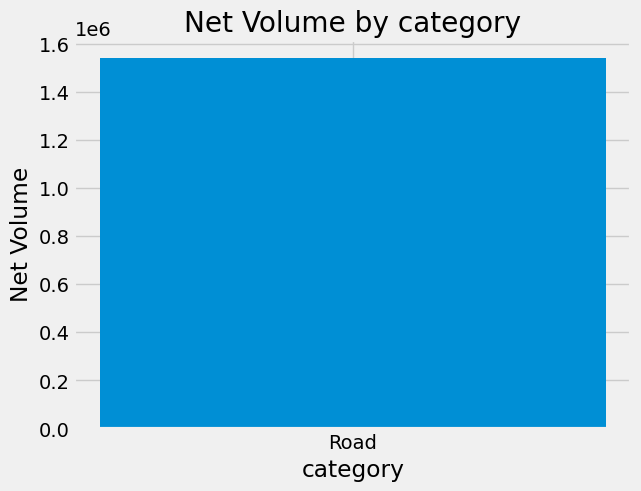

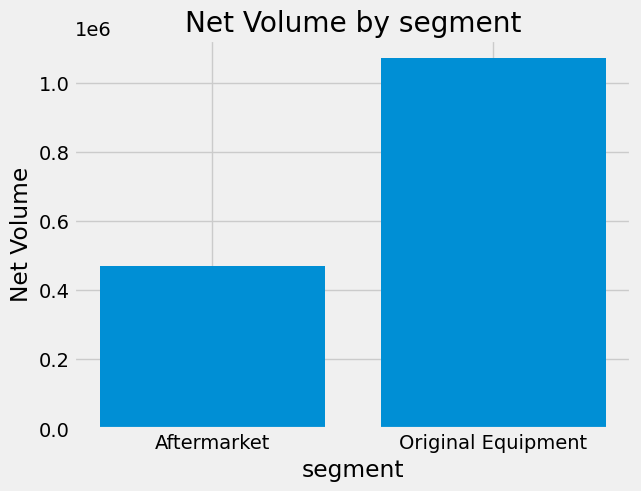

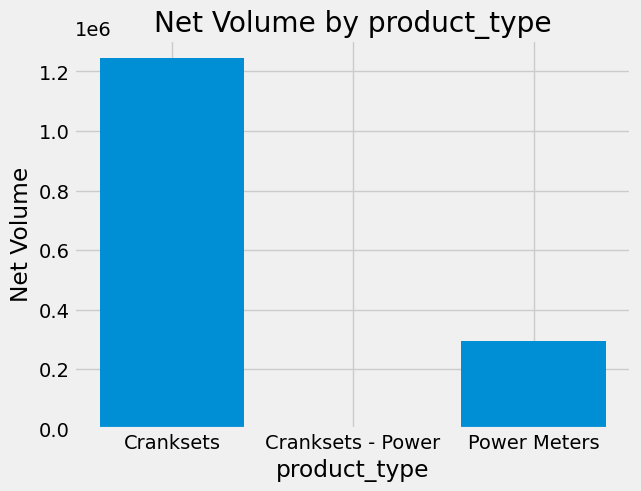

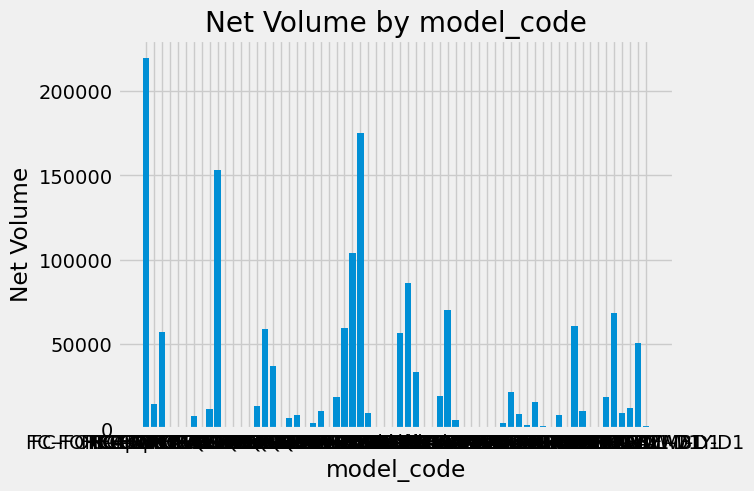

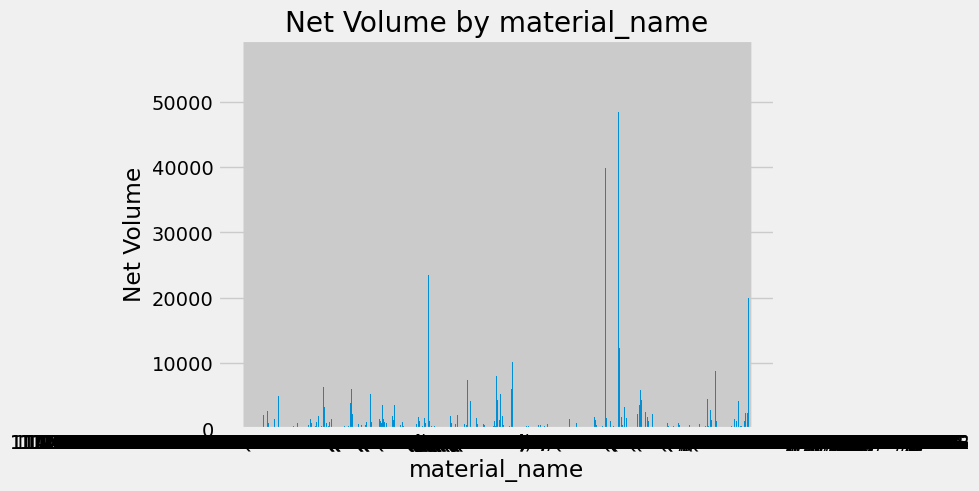

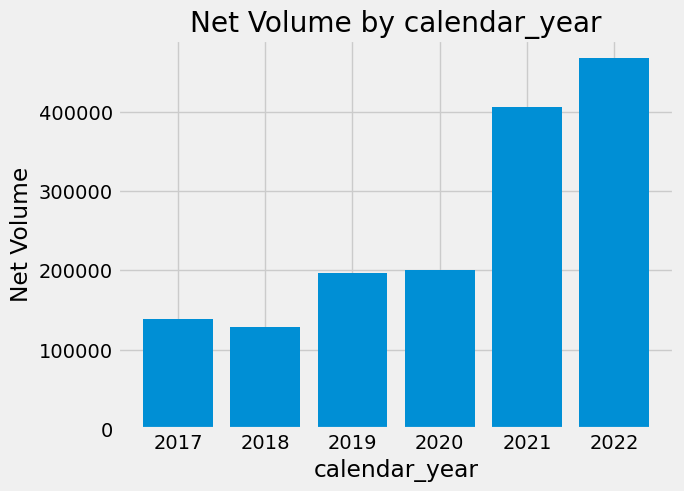

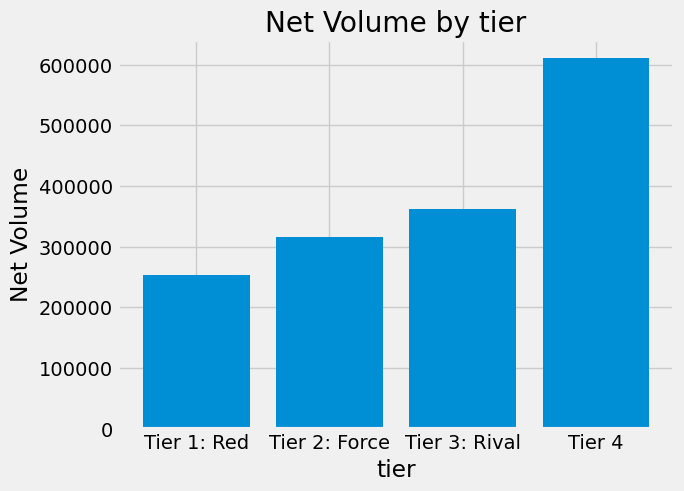

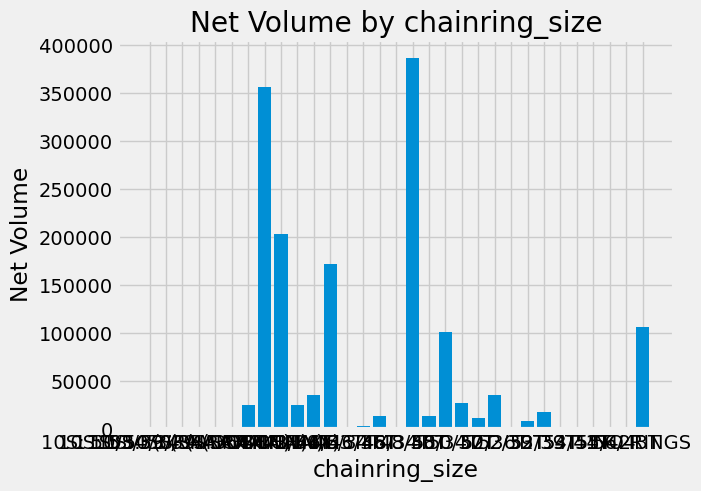

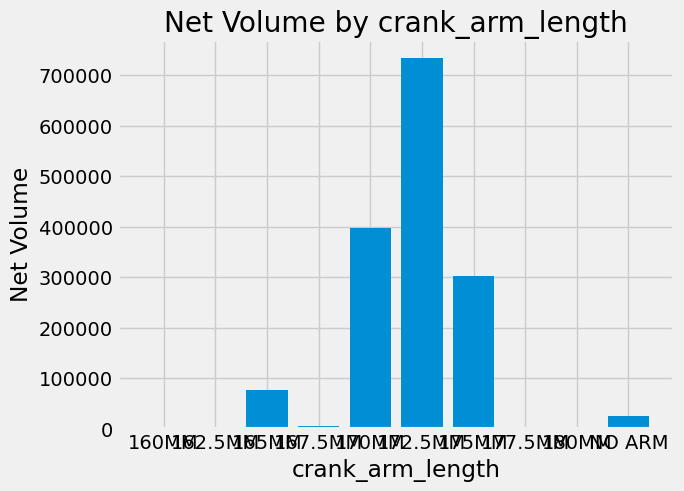

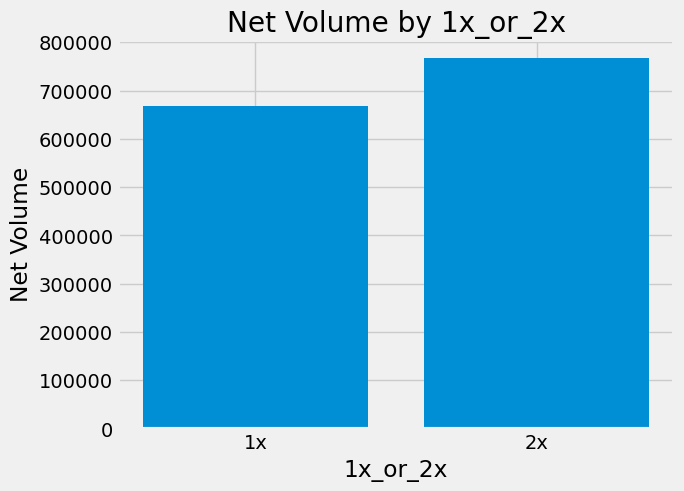

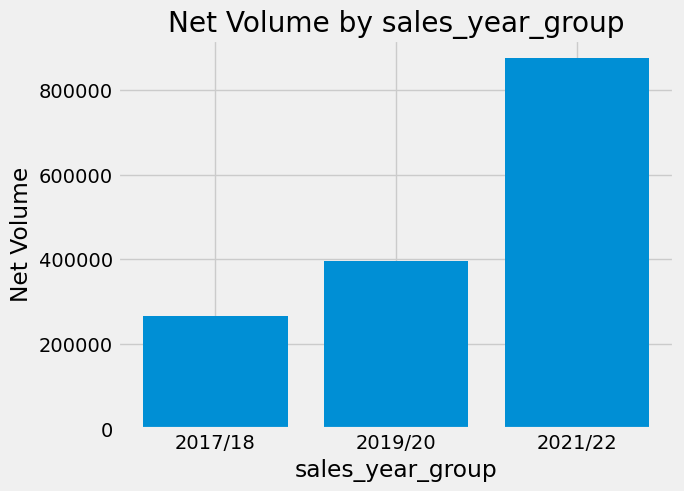

In [14]:
# # Get the list of categorical variables
# categorical_vars = [col for col in df.columns if df[col].dtype == 'object']

# # Create a chart for each categorical variable
# for var in categorical_vars:
#     # Group the data by the categorical variable and sum the net_volume
#     sales_by_cat = df.groupby(var)['net_volume'].sum()
    
#     # Create a bar chart of the net_volume by category
#     fig, ax = plt.subplots()
#     ax.bar(sales_by_cat.index, sales_by_cat.values)
#     ax.set_xlabel(var)
#     ax.set_ylabel('Net Volume')
#     ax.set_title('Net Volume by {}'.format(var))
#     plt.show()

From 2017 to 2023 without filtering...<br>
-Across many categories there are products that aren't visible when plotted. Volume data skewed towards few products  <br>
-Overall tier sales follow inverse price trend (tier 4 sells the most, tier 1 sells least) <br>
-net_volume has increased through time <br>
-original equipment is has been sold ~ 2:1 compared to aftermarket <br> 

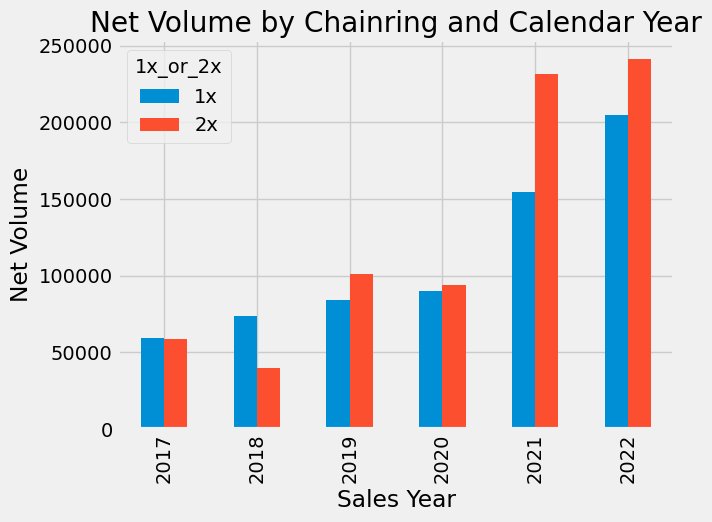

In [15]:
sales_by_year_and_chainring = df.groupby(['calendar_year', '1x_or_2x'])['net_volume'].sum()

# Pivot the data to create a DataFrame with sales_year_group as index, 1x_or_2x as columns, and net_volume as values
sales_pivot = df.pivot_table(values='net_volume', index='calendar_year', columns='1x_or_2x', aggfunc='sum')

# Plot the net_volume for each 1x_or_2x by sales_year_group
sales_pivot.plot(kind='bar')
plt.xlabel('Sales Year')
plt.ylabel('Net Volume')
plt.title('Net Volume by Chainring and Calendar Year')
plt.show()

This illustrates how 2x chainrings are the leading chainring spec for SRAM. Even though net 1x sales have doubled from 17/18 -> 21/22, 2x chainrings have been dominant for the past two sales years.<br> Next steps are to understand which types of 1x and 2x chainrings have been driving these changes

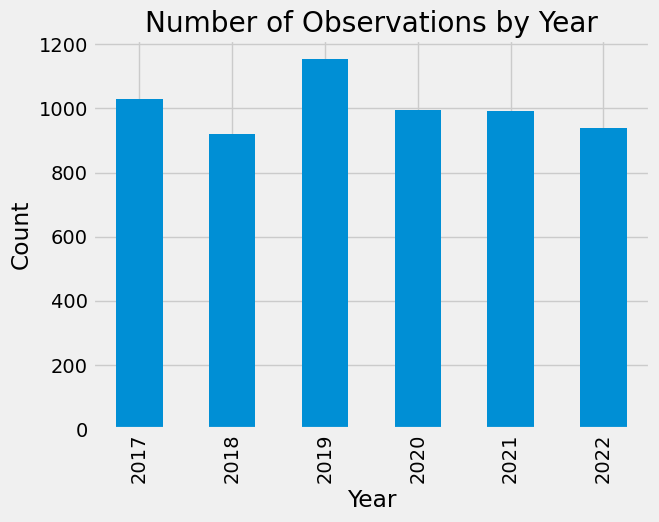

In [16]:
year_counts = df['calendar_year'].value_counts().sort_index()

# Create a bar plot of the year counts
ax = year_counts.plot(kind='bar')

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Number of Observations by Year')

# Show the plot
plt.show()

Text(0, 0.5, 'Sales Year Group')

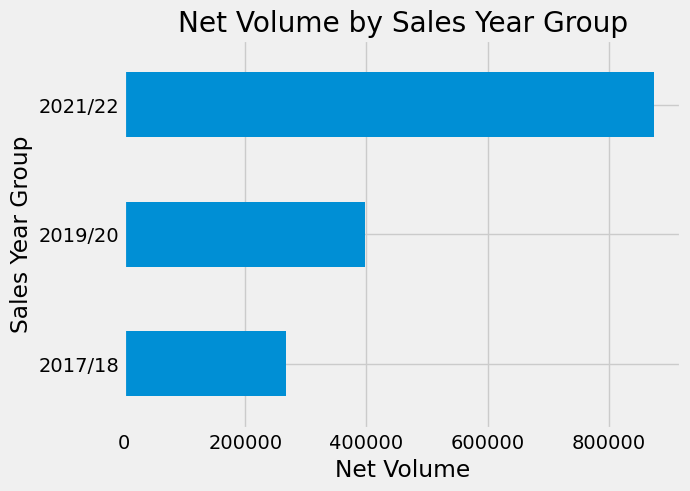

In [17]:
ax = df.groupby('sales_year_group')['net_volume'].sum() \
    .plot(kind = 'barh', title = 'Net Volume by Sales Year Group') 
ax.set_xlabel('Net Volume')
ax.set_ylabel('Sales Year Group')

Number of sales were highest in 19/20, but net_volume is significantly higher in 21/22. Trending towards fewer sales with larger volumes

### 1x analysis

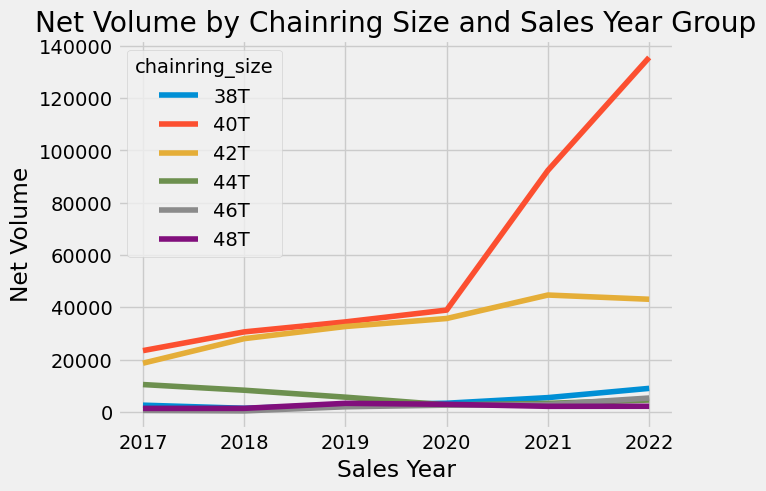

In [19]:
df1 = df[df['1x_or_2x'] == '1x']

# Get the top 6 chainrings in terms of net_volume
top_chainrings = df1.groupby('chainring_size')['net_volume'].sum().nlargest(6).index

# Filter the data to include only the top 6 chainring sizes
top_1x = df1[df1['chainring_size'].isin(top_chainrings)]

# Pivot the data to create a DataFrame with sales_year_group as index, chainring_size as columns, and net_volume as values
sales_pivot = top_1x.pivot_table(values='net_volume', index='calendar_year', columns='chainring_size', aggfunc='sum')

# Plot the net_volume for each chainring_size by sales_year_group
sales_pivot.plot()
plt.xlabel('Sales Year')
plt.ylabel('Net Volume')
plt.title('Net Volume by Chainring Size and Sales Year Group')
plt.show()

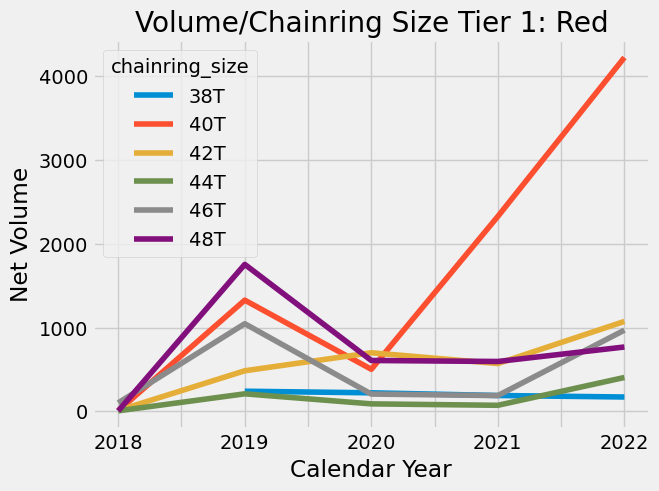

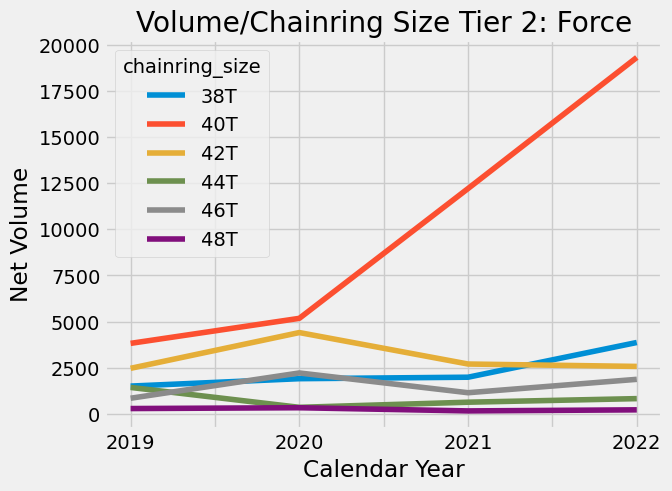

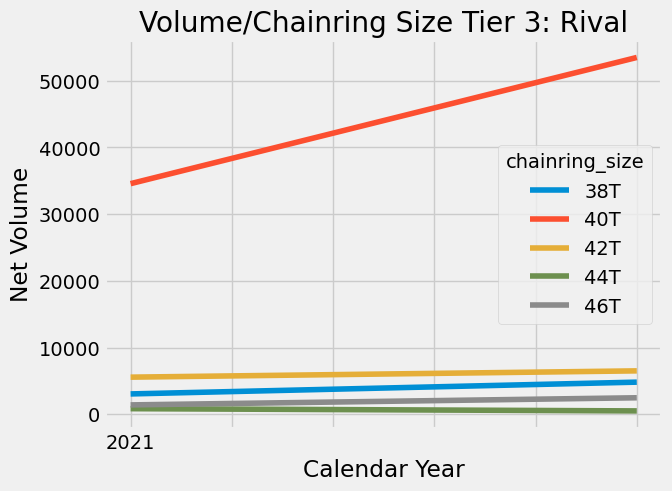

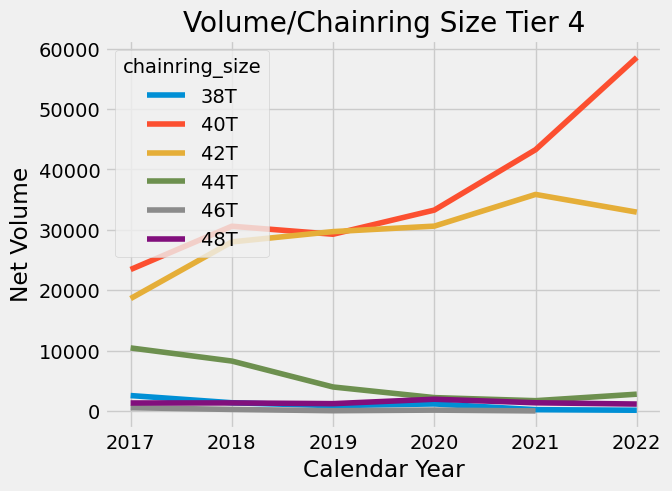

In [20]:
# Filter the data to include only '1x' CRs
df1 = df[df['1x_or_2x'] == '1x']

# Get the top 6 chainrings in terms of net_volume
top_chainrings = df1.groupby('chainring_size')['net_volume'].sum().nlargest(6).index

# Define a color palette with the desired colors
palette = sns.color_palette('deep', n_colors=len(top_chainrings))

# Loop through each tier and create a separate plot for each
for tier in df1['tier'].unique():
    # Filter the data for the current tier
    tier_data = df1[df1['tier'] == tier]

    # Filter the data to include only the top 6 CRs
    top_1x = tier_data[tier_data['chainring_size'].isin(top_chainrings)]

    # Filter the data to include only the 'calendar_year', 'chainring_size', and 'tier' categories
    df_tier = top_1x[['calendar_year', 'chainring_size', 'tier', 'net_volume']]

    # Group the data by 'tier', 'chainring_size', and 'calendar_year' and calculate the sum of 'net_volume' for each group
    grouped = df_tier.groupby(['tier', 'chainring_size', 'calendar_year'])['net_volume'].sum()

    # Pivot the data to create a DataFrame with 'calendar_year' as index, 'chainring_size' as columns, and 'net_volume' as values
    sales_pivot = grouped.reset_index().pivot_table(values='net_volume', index='calendar_year', columns='chainring_size', aggfunc='sum')
    
    
    # Plot the net_volume for each chainring_size by calendar_year for the current tier
    ax = sales_pivot.plot()
    ax.set_xlabel('Calendar Year')
    ax.set_ylabel('Net Volume')
    ax.set_title(f'Volume/Chainring Size {tier}')
    ax.set_prop_cycle(color=palette)
    plt.show()


In [40]:
df1 = df[df['1x_or_2x'] == '1x']

# group the DataFrame by category and year, and calculate the total sales for each group
grouped = df1.groupby(['chainring_size','calendar_year']).sum().reset_index()

# transform so that each year becomes a separate column
pivoted = grouped.pivot(index='chainring_size', columns='calendar_year', values='net_volume')

# use pct_change to calculate the percent change in net_volume between each year
percent_change = pivoted.pct_change(axis='columns') 
pd.DataFrame(percent_change)
# print the results
percent_change

calendar_year,2017,2018,2019,2020,2021,2022
chainring_size,,,,,,
36T,NaN,NaN,NaN,0.102258,-0.574699,-0.651558
38T,NaN,-0.460465,0.904454,0.253866,0.645608,0.646435
40T,NaN,0.305694,0.124722,0.131484,1.371564,0.467469
42T,NaN,0.503783,0.165757,0.093731,0.251217,-0.036147
44T,NaN,-0.207071,-0.320077,-0.524105,0.220112,0.386752
46T,NaN,-0.331010,4.119792,0.319430,0.070547,0.913576
48T,NaN,0.013333,1.399123,-0.112736,-0.265110,0.009813
50T,NaN,0.861821,-0.240239,-0.179630,-0.173251,0.144710
52T,NaN,-0.014184,0.279137,0.295838,0.677951,0.387998


In [22]:
df1.groupby(['chainring_size'])['net_volume'].agg(['sum','count','mean','min','max']).sort_values('sum', ascending = False)

,sum,count,mean,min,max
chainring_size,,,,,
40T,355411,649,547.628659,1,24254
42T,202852,629,322.499205,1,6949
44T,34909,248,140.762097,1,2475
38T,24423,227,107.590308,1,2591
46T,13609,250,54.436000,1,825
48T,13213,156,84.698718,1,1052
50T,11444,231,49.541126,1,486
52T,8057,65,123.953846,1,2105
36T,2059,73,28.205479,1,328


There are 11 unique chainring sizes for 1x systems. 40T and 42T chainrings are clearly favorites by net volume.

### 2x Analysis

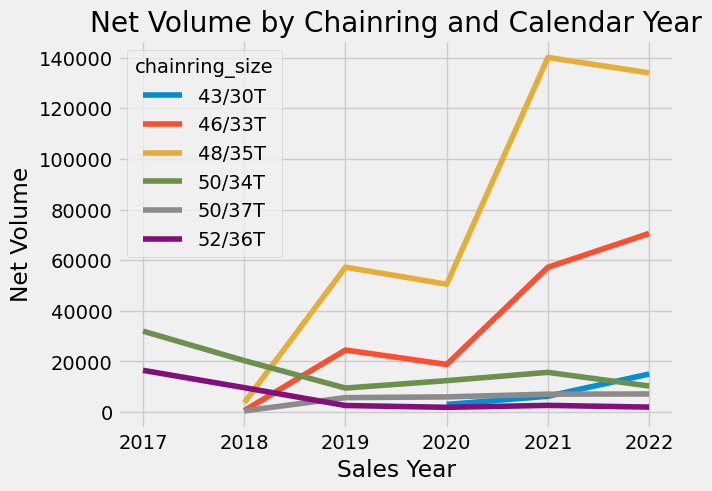

In [23]:
df1 = df[df['1x_or_2x'] == '2x']

# Get the top 6 chainrings in terms of net_volume
top_chainrings = df1.groupby('chainring_size')['net_volume'].sum().nlargest(6).index

# Filter the data to include only the top 6 chainring sizes
top_1x = df1[df1['chainring_size'].isin(top_chainrings)]

# Pivot the data to create a DataFrame with sales_year_group as index, chainring_size as columns, and net_volume as values
sales_pivot = top_1x.pivot_table(values='net_volume', index='calendar_year', columns='chainring_size', aggfunc='sum')

# Plot the net_volume for each chainring_size by sales_year_group
sales_pivot.plot()
plt.xlabel('Sales Year')
plt.ylabel('Net Volume')
plt.title('Net Volume by Chainring and Calendar Year')
plt.show()

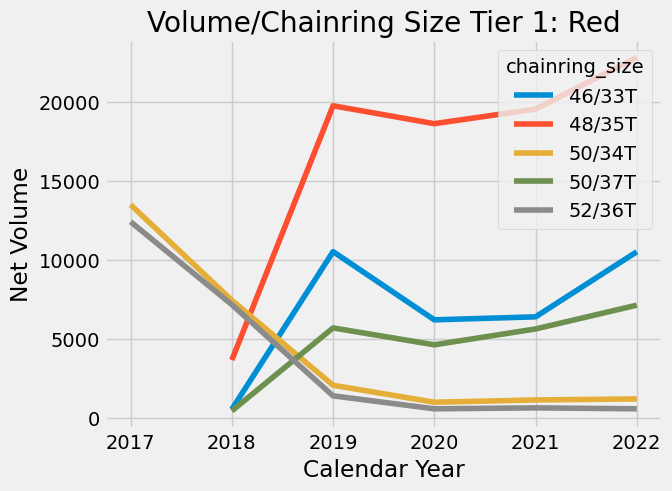

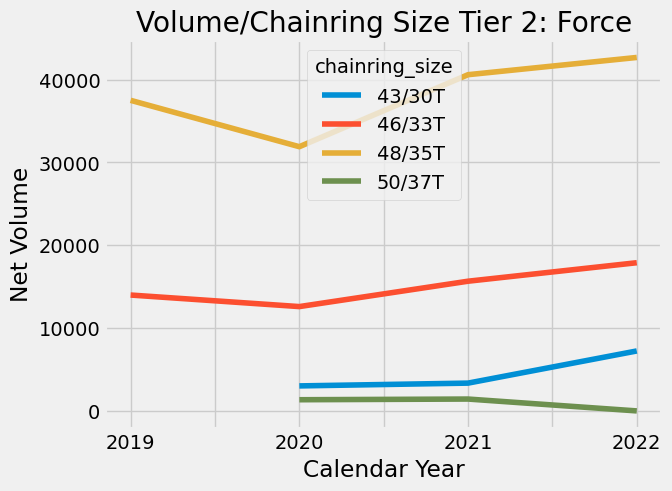

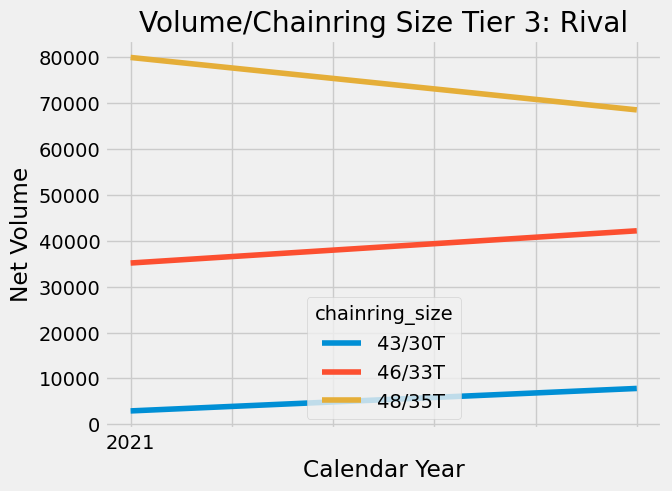

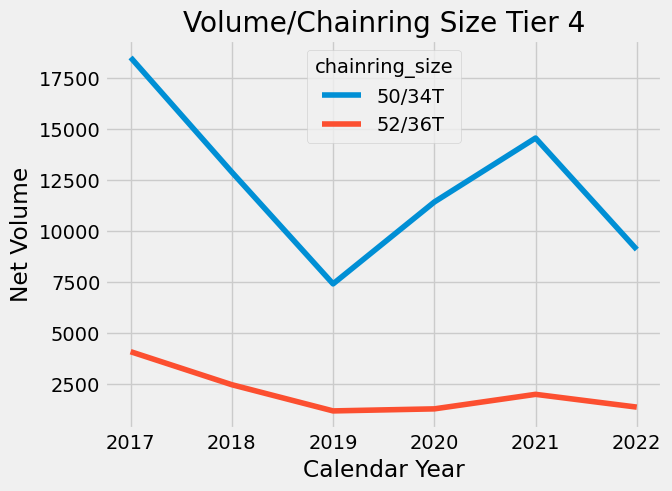

In [24]:
# Filter the data to include only '2x' CRs
df1 = df[df['1x_or_2x'] == '2x']

# Get the top 6 chainrings in terms of net_volume
top_chainrings = df1.groupby('chainring_size')['net_volume'].sum().nlargest(6).index

# Define a color palette with the desired colors
palette = sns.color_palette('deep', n_colors=len(top_chainrings))

# Loop through each tier and create a separate plot for each
for tier in df1['tier'].unique():
    # Filter the data for the current tier
    tier_data = df1[df1['tier'] == tier]

    # Filter the data to include only the top 6 CRs
    top_2x = tier_data[tier_data['chainring_size'].isin(top_chainrings)]

    # Filter the data to include only the 'calendar_year', 'chainring_size', and 'tier' categories
    df_tier = top_2x[['calendar_year', 'chainring_size', 'tier', 'net_volume']]

    # Group the data by 'tier', 'chainring_size', and 'calendar_year' and calculate the sum of 'net_volume' for each group
    grouped = df_tier.groupby(['tier', 'chainring_size', 'calendar_year'])['net_volume'].sum()

    # Pivot the data to create a DataFrame with 'calendar_year' as index, 'chainring_size' as columns, and 'net_volume' as values
    sales_pivot = grouped.reset_index().pivot_table(values='net_volume', index='calendar_year', columns='chainring_size', aggfunc='sum')

    # Plot the net_volume for each chainring_size by calendar_year for the current tier
    ax = sales_pivot.plot()
    ax.set_xlabel('Calendar Year')
    ax.set_ylabel('Net Volume')
    ax.set_title(f'Volume/Chainring Size {tier}')
    ax.set_prop_cycle(color=palette)
    plt.show()

In [25]:
df1.groupby(['chainring_size'])['net_volume'].agg(['sum','count','mean','min','max']).sort_values('sum', ascending = False)

,sum,count,mean,min,max
chainring_size,,,,,
48/35T,385680,427,903.231850,1,27255
46/33T,171777,425,404.181176,1,16966
50/34T,100245,665,150.744361,1,3296
52/36T,35278,339,104.064897,1,1979
50/37T,26423,168,157.279762,1,1919
43/30T,24329,94,258.819149,1,2674
53/39T,17707,361,49.049861,1,1857
46/36T,3048,146,20.876712,1,185
52/39T,1091,4,272.750000,38,495


In [39]:
df1 = df[df['1x_or_2x'] == '2x']

# group the DataFrame by category and year, and calculate the total sales for each group
grouped = df1.groupby(['chainring_size','calendar_year']).sum().reset_index()

# transform so that each year becomes a separate column
pivoted = grouped.pivot(index='chainring_size', columns='calendar_year', values='net_volume')

# use pct_change to calculate the percent change in net_volume between each year
percent_change = pivoted.pct_change(axis='columns') 
pd.DataFrame(percent_change)
# print the results
percent_change

calendar_year,2017,2018,2019,2020,2021,2022
chainring_size,,,,,,
10S: 50/34,NaN,NaN,NaN,0.000000,0.000000,0.000000
10S: 50/34 (SRAM CHAIN),NaN,0.000000,0.000000,0.000000,0.000000,0.000000
10S: 53/39 (SRAM CHAIN),NaN,0.111111,0.000000,0.000000,0.000000,0.000000
11S: 50/34 (SRAM CHAIN),NaN,0.000000,15.500000,0.000000,0.000000,0.000000
11S: 53/39 (SRAM CHAIN),NaN,0.000000,0.000000,0.000000,0.000000,0.000000
43/30T,NaN,NaN,NaN,NaN,1.071452,1.402427
46/33T,NaN,NaN,42.115993,-0.232625,2.040317,0.233678
46/34T,NaN,0.000000,0.000000,-0.958333,69.000000,0.121429
46/36T,NaN,-0.335174,-0.778173,0.401070,0.335878,-0.605714


### Crankarm Length Analysis

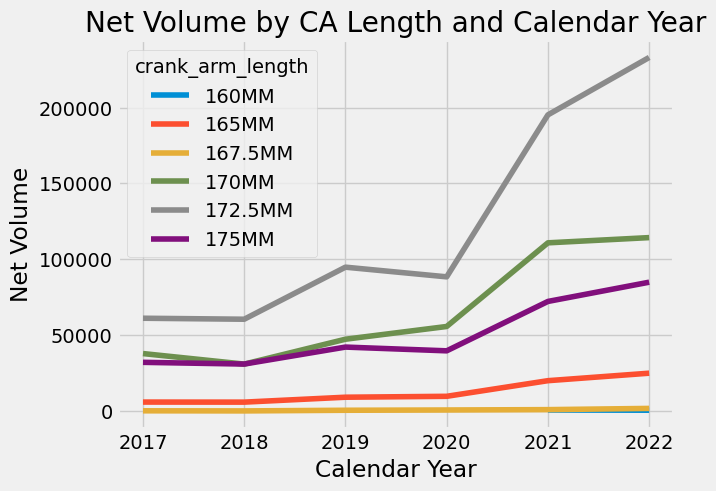

In [27]:
#filter out NO ARM (aka BB powermeters/only CR)
df1 = df[df['crank_arm_length'] != 'NO ARM']

# Get the top 6 crank_arm_length in terms of net_volume
top_crank_arm_lengths = df1.groupby('crank_arm_length')['net_volume'].sum().nlargest(6).index

# Filter the data to include only the top 6 crank_arm_length
df1 = df[df['crank_arm_length'].isin(top_crank_arm_lengths)]


# Group the data by sales_year_group and crank_arm_length and sum the net_volume
sales_by_year_and_crank_arm_length = df1.groupby(['calendar_year', 'crank_arm_length'])['net_volume'].sum()

# Pivot the data to create a DataFrame with sales_year_group as index, crank_arm_length as columns, and net_volume as values
sales_pivot = df1.pivot_table(values='net_volume', index='calendar_year', columns='crank_arm_length', aggfunc='sum')

# Plot the net_volume for each crank_arm_length by sales_year_group
sales_pivot.plot()
plt.xlabel('Calendar Year')
plt.ylabel('Net Volume')
plt.title('Net Volume by CA Length and Calendar Year')
plt.show()

Top 4 CA lengths in absolute sales
1. 172.5mm
2. 170mm
3. 175mm
4. 165mm

-Inluding top 6 to keep chart uncluttered<br>
-Ranking is consistent through time. 165mm accounts for much lower share of net_volume, does not seem to grow at equivalent rate<br>
-filtered out NO ARM 

In [28]:
#summary table sales year
df1 = df[df['sales_year_group']!= '2023'] 
df1.groupby(['sales_year_group','crank_arm_length'])['net_volume'].agg(['sum']).reset_index()

,sales_year_group,crank_arm_length,sum
0,2017/18,162.5MM,323
1,2017/18,165MM,11847
2,2017/18,167.5MM,309
3,2017/18,170MM,68849
4,2017/18,172.5MM,121689
5,2017/18,175MM,63106
6,2017/18,177.5MM,650
7,2017/18,180MM,300
8,2017/18,NO ARM,6
9,2019/20,162.5MM,128


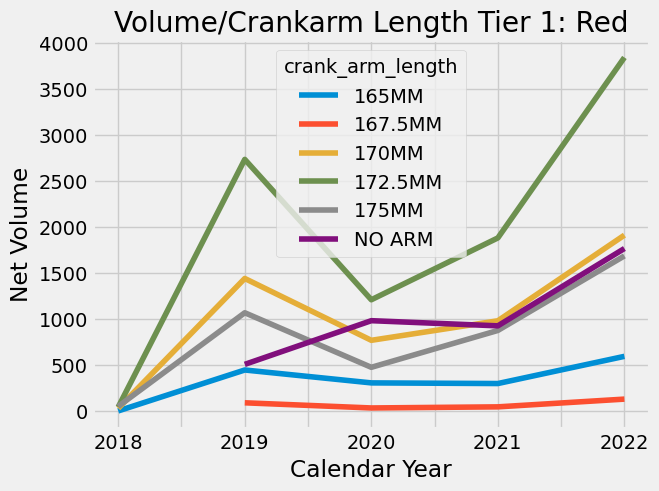

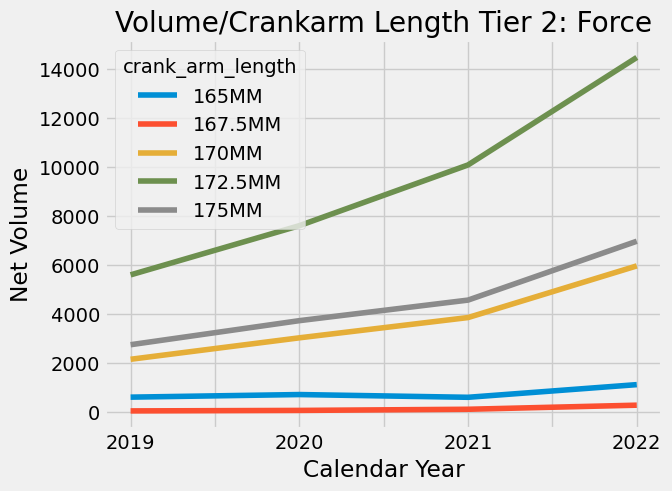

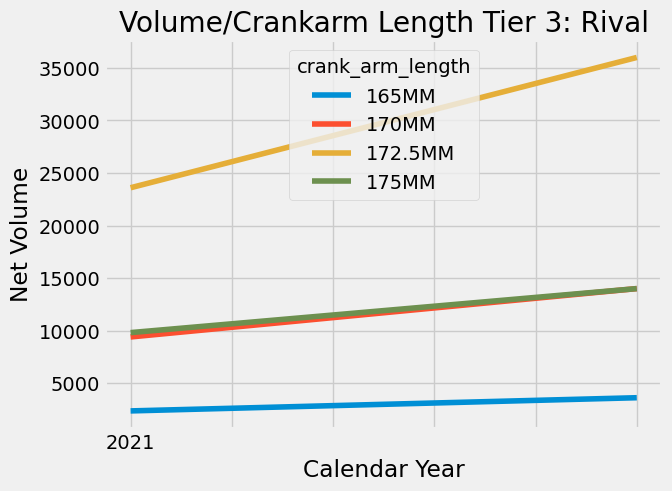

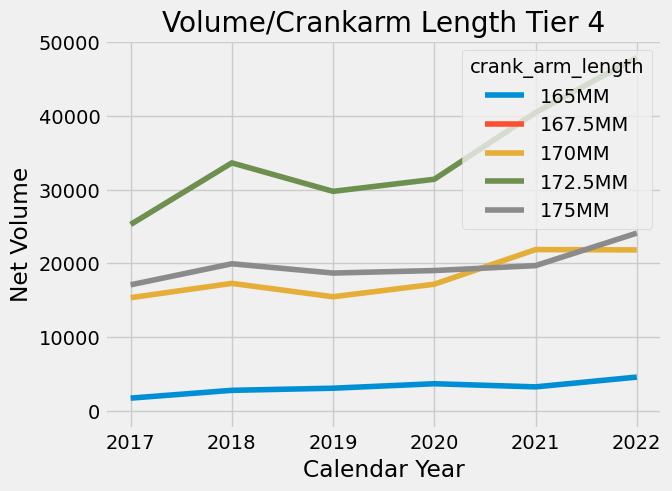

In [63]:
# Get the top 6 chainrings in terms of net_volume
top_crankarms = df1.groupby('crank_arm_length')['net_volume'].sum().nlargest(6).index

# Define a color palette with the desired colors
palette = sns.color_palette('deep', n_colors=len(top_crankarms))

# Loop through each tier and create a separate plot for each
for tier in df1['tier'].unique():
    # Filter the data for the current tier
    tier_data = df1[df1['tier'] == tier]

    # Filter the data to include only the top 6 CRs
    top_ca = tier_data[tier_data['crank_arm_length'].isin(top_crankarms)]

    # Filter the data to include only the 'calendar_year', 'chainring_size', and 'tier' categories
    df_tier = top_ca[['calendar_year', 'crank_arm_length', 'tier', 'net_volume']]

    # Group the data by 'tier', 'chainring_size', and 'calendar_year' and calculate the sum of 'net_volume' for each group
    grouped = df_tier.groupby(['tier', 'crank_arm_length', 'calendar_year'])['net_volume'].sum()

    # Pivot the data to create a DataFrame with 'calendar_year' as index, 'chainring_size' as columns, and 'net_volume' as values
    sales_pivot = grouped.reset_index().pivot_table(values='net_volume', index='calendar_year', columns='crank_arm_length', aggfunc='sum')

    # Plot the net_volume for each chainring_size by calendar_year for the current tier
    ax = sales_pivot.plot()
    ax.set_xlabel('Calendar Year')
    ax.set_ylabel('Net Volume')
    ax.set_title(f'Volume/Crankarm Length {tier}')
    ax.set_prop_cycle(color=palette)
    plt.show()

In [64]:
df1.groupby(['crank_arm_length'])['net_volume'].agg(['sum','count','mean','min','max']).sort_values('sum', ascending = False)

,sum,count,mean,min,max
crank_arm_length,,,,,
172.5MM,315431,730,432.097260,1,24254
175MM,164534,638,257.890282,1,11266
170MM,152513,681,223.954479,1,9078
165MM,29831,331,90.123867,1,3042
NO ARM,4181,26,160.807692,2,491
167.5MM,775,93,8.333333,1,96
160MM,349,12,29.083333,1,103
177.5MM,111,31,3.580645,1,13
162.5MM,11,5,2.200000,1,5


In [41]:
# group the DataFrame by category and year, and calculate the total sales for each group
grouped = df1.groupby(['crank_arm_length','calendar_year']).sum().reset_index()

# transform so that each year becomes a separate column
pivoted = grouped.pivot(index='crank_arm_length', columns='calendar_year', values='net_volume')

# use pct_change to calculate the percent change in net_volume between each year
percent_change = pivoted.pct_change(axis='columns')
pd.DataFrame(percent_change)
# print the results
percent_change

calendar_year,2017,2018,2019,2020,2021,2022
crank_arm_length,,,,,,
160MM,NaN,NaN,NaN,NaN,NaN,-0.305825
162.5MM,NaN,-0.900000,0.000000,0.000000,0.000000,0.000000
165MM,NaN,0.608971,0.475340,0.138808,0.390555,0.518739
167.5MM,NaN,NaN,20.166667,-0.283465,0.648352,1.673333
170MM,NaN,0.128192,0.100462,0.100000,0.722455,0.210146
172.5MM,NaN,0.332173,0.131268,0.055747,0.890365,0.344719
175MM,NaN,0.169747,0.124862,0.032452,0.505188,0.337662
177.5MM,NaN,0.500000,0.333333,-0.650000,0.000000,-0.500000
NO ARM,NaN,NaN,NaN,0.933071,-0.057026,0.906048


In [59]:
#calculate net_volume per 1x CR as a percentage of total 1x CR net_volume 
df_1x = df[df['1x_or_2x'] == '1x']

df_1x.groupby('chainring_size')['net_volume'].sum()

chainring_size
36T      2059
38T     24423
40T    355411
42T    202852
44T     34909
46T     13609
48T     13213
50T     11444
52T      8057
53T       400
54T      1359
Name: net_volume, dtype: int64

In [60]:
df_1x['net_volume'].sum()

667736

In [57]:
#calculate net_volume per 2x CR as a percentage of total 2x CR net_volume 
df_2x = df[df['1x_or_2x'] == '2x']

df_2x.groupby('chainring_size')['net_volume'].sum()

chainring_size
10S: 50/34                     70
10S: 50/34 (SRAM CHAIN)        23
10S: 53/39 (SRAM CHAIN)        19
11S: 50/34 (SRAM CHAIN)        70
11S: 53/39 (SRAM CHAIN)         3
43/30T                      24329
46/33T                     171777
46/34T                        347
46/36T                       3048
48/34T                        128
48/35T                     385680
50/34T                     100245
50/37T                      26423
52/36T                      35278
52/39T                       1091
53/39T                      17707
54/41T                        489
55/42T                         48
56/43T                        219
Name: net_volume, dtype: int64

In [58]:
df_2x['net_volume'].sum()

766994

In [52]:
#calculate net_volume per crankarm as a percentage of total crankarm net_volume 
#grouped = df1.groupby(['crank_arm_length']).sum()
crank_df = df[df['product_type'] == 'Power Meters']

crank_df.groupby('crank_arm_length')['net_volume'].sum()

crank_arm_length
160MM         601
162.5MM       419
165MM       17678
167.5MM       499
170MM       70095
172.5MM    134659
175MM       45547
177.5MM       304
NO ARM      24462
Name: net_volume, dtype: int64

In [54]:
crank_df['net_volume'].sum()

294264

In [32]:
# df['customer_type'] = pd.cut(df['net_volume'], [0,2,100,1000,27255], labels=['individual','bike shop','small manufacturer', 'large manufacturer'])